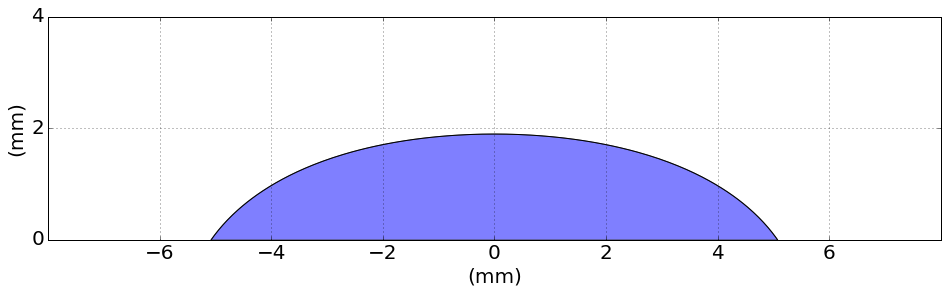

In [1]:
#Boilerplates
%matplotlib inline
from ipywidgets import widgets
from IPython import display
import matplotlib.pylab as plt #plotting
import numpy as np #linspace and array
from scipy.integrate import odeint #ODE integration
from scipy.optimize import fmin #find minimum of a function using clever algorithms
from math import * #mathematical functions

#ODE to integrate the droplet surface in X and Y direction as a function of psi
def droplet_ode(y,psi):
    global B, l
    Q=y[0]/(l**2)-B
    dxdpsi=sin(psi)/Q
    dydpsi=-cos(psi)/Q
    return np.array([dxdpsi,dydpsi])

#return value is the error between given and the calculated area
def findB(b):
    global B, AD, yinit, psis #Python assumes without global derective that B would be a local variable
    B=b[0] #b is an array of size 1, but B a float
    yy=odeint(droplet_ode,yinit,psis) #solve the ODE with initial values and for the psis
    droparea=2*np.trapz(np.fabs(yy[:,1]),x=np.fabs(yy[:,0]))
    return fabs(AD-droparea)

#initialize and plot the curv
def plotall(newvalue):
    global B, AD, yinit, psis, l

    g=w_g.value #gravity
    alpha=w_alpha.value/180.*pi #contact angle
    gamma=w_gamma.value #surface tension coefficient
    rho=w_rho.value #density difference droplet and surrounding liquid
    
    l=sqrt(gamma/g/rho) #capillary number

    AD=pi*(3e-3)**2/2. #area of the droplet
    
    #Psi we want to calculate
    psis = np.linspace(0., alpha, 100.) #List of psi's

    #estimate for intital curvature B based on a circle and account for the contact angle
    r=sqrt(AD/(alpha-0.5*sin(2*alpha))) #radius of a cut circle with contact angle alpha
    initialB=1/r #and set as initial B as an approximation of Eq. (3)

    #Initial value for X and Y
    yinit=np.array([0,0])
    
    newB = fmin(func=findB, x0=initialB,disp=0)
    B=newB[0]
    
    #Calculate final shape with correct B
    yy=odeint(droplet_ode,yinit,psis)
    
    #Plotting
    x=yy[:,0]*1e3
    x=x-x[-1]
    y=yy[:,1]*1e3
    if (x.min() <0.):
        x=-x
    plt.figure(1, figsize=(16, 6), dpi=200)
    plt.clf()
    y=np.append(np.flipud(-y),y)
    x=np.append(np.flipud(x),x)
    plt.plot(y,x,'k')
    
    plt.gca().fill_between(y, 0, x, facecolor='blue', alpha=0.5)
    
    plt.xlim(-8, 8)
    plt.ylim(0, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks((-6, -4, -2, 0 , 2, 4, 6), color='k', size=20)
    plt.yticks((0, 2, 4), color='k', size=20)
    plt.xlabel('(mm)',fontsize=20)
    plt.ylabel('(mm)',fontsize=20)
    plt.gca().grid(True)
   
    display.clear_output(wait=True)

def select_fluid(newvalue):
    if (w_select.value=='mercury'):
        w_rho.value=5430.
        w_alpha.value=140.
        w_gamma.value=0.5
    if (w_select.value=='water'):
        w_rho.value=1000.
        w_alpha.value=30.
        w_gamma.value=0.072
    if (w_select.value=='oil'):
        w_rho.value=790.
        w_alpha.value=90.
        w_gamma.value=0.02        
    plotall(1)

#Main program starts which builds the GUI    
w_g=widgets.FloatSlider(min=.25,max=20.,step=.25,\
                        value=10,description='gravity constant (m/s^2):')
w_alpha=widgets.FloatSlider(min=20,max=160.,step=5,\
                        value=30,description='contact angle (degree)..:')
w_rho=widgets.FloatSlider(min=500.,max=6000.,step=250,\
                        value=1000,description='density (kg/m^3)...........:')
w_gamma=widgets.FloatSlider(min=0.02,max=0.5,step=0.01,\
                        value=0.07,description='surface tension (N/m)...:')
w_select=widgets.ToggleButtons(description='Liquid on glass:',\
                               options=['water', 'oil', 'mercury'])
w_top=widgets.HTML(value="""
            <h2> Droplet on a surface</h2>
            <p>This program calculates the shape of a droplet in
            a gravitational field balancing surface energy and potential energy.</p>
            <p>Change the constants or select a liquid.
            </p><hr>
            """)
w_g.observe(plotall, names='value')
w_alpha.observe(plotall, names='value')
w_rho.observe(plotall, names='value')
w_gamma.observe(plotall, names='value')
w_select.observe(select_fluid, names='value')
display.display(w_top,w_select,w_g,w_alpha,w_rho,w_gamma,);
plotall(1) #and plot